In [75]:
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import numpy as np
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [76]:
search_term = ("BBC", "CBS", "CNN", "Fox", "nytimes")

min_tweets = 5
min_followers = 5000
max_following = 2500
lang = "en"

results_list = []
overall_result =[]
sentiment=[]
overall_sentiment =[]
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for target in search_term:
    counter=1
    oldest_tweet = None
    for x in range(1, 6):
        public_tweets = api.user_timeline(target, max_id=oldest_tweet)
        for tweet in public_tweets:
            if (tweet["user"]["statuses_count"] > min_tweets and
                tweet["user"]["followers_count"] > min_followers and
                tweet["user"]["friends_count"] < max_following and
                tweet["user"]["lang"] == lang):
 
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                pos = results['pos']
                neu = results["neu"]
                neg = results["neg"]
                compound_list.append(compound)
                positive_list.append(pos)
                negative_list.append(neg)  
                neutral_list.append(neu)
                oldest_tweet = tweet["id"] - 1
                sentiment = {
                           "Source account":target,
                           "Compound":compound,
                           "pos":pos,
                           "neg":neg,
                           "neu":neu,
                           "Date":tweet["created_at"],
                           "Tweets Ago":counter
                            }
                results_list.append(sentiment)
                counter += 1              
    overall_sentiment = {
            "Media Source": target,
            "Compound":np.mean(compound_list),
            "pos":np.mean(positive_list),
            "neg":np.mean(negative_list),
            "neu":np.mean(neutral_list),
        }
    overall_result.append(overall_sentiment)

In [77]:
news_df = pd.DataFrame(results_list)
news_df['Source account'] = news_df['Source account'].map({"BBC":"BBC","CBS":"CBS","CNN":"CNN","Fox":"Fox",'nytimes': "New York Times"})
news_df.to_csv("Media sentiment by Twitter.csv", index=False, header=True)
news_df.head()

,Compound,Date,Source account,Tweets Ago,neg,neu,pos
0,0.0000,Sat Jun 23 20:12:00 +0000 2018,BBC,1,0.0,1.000,0.000
1,0.0000,Sat Jun 23 19:02:02 +0000 2018,BBC,2,0.0,1.000,0.000
2,0.5719,Sat Jun 23 17:06:01 +0000 2018,BBC,3,0.0,0.821,0.179
3,0.7412,Sat Jun 23 16:02:02 +0000 2018,BBC,4,0.0,0.614,0.386
4,0.4019,Sat Jun 23 15:00:27 +0000 2018,BBC,5,0.0,0.847,0.153


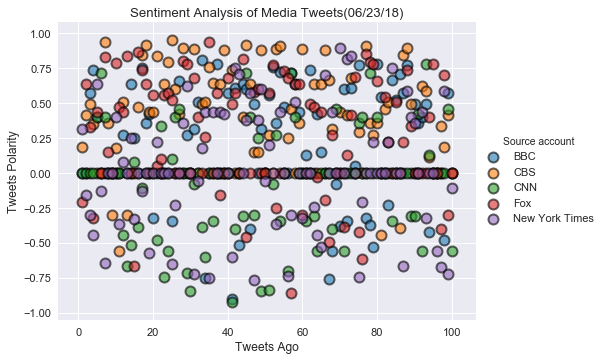

In [78]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("darkgrid")  #ticks
sns.lmplot('Tweets Ago', # Horizontal axis
           'Compound', # Vertical axis
           data=news_df, hue= 'Source account',# Data source
           fit_reg=False, # Don't fix a regression line
           legend_out=True,aspect=1.4,scatter_kws={"s": 100,'alpha':0.6,'edgecolors':"black",'linewidth':2}) # Set color # S marker size

plt.xlabel("Tweets Ago")
plt.ylabel("Tweets Polarity")
plt.title("Sentiment Analysis of Media Tweets(06/23/18)")
plt.savefig("Sentiment Analysis.png")
plt.show()

In [82]:
over_all_sentiment_df = pd.DataFrame(data=overall_result)
over_all_sentiment_df['Media Source'] = over_all_sentiment_df['Media Source'].map({"BBC":"BBC","CBS":"CBS","CNN":"CNN","Fox":"Fox",'nytimes': "NYT"})
over_all_sentiment_df = over_all_sentiment_df.set_index("Media Source")
over_all_sentiment_df.to_csv("Overall media sentiment by Twitter.csv", index=True, header=True)
over_all_sentiment_df

,Compound,neg,neu,pos
Media Source,,,,
BBC,0.183599,0.048490,0.843260,0.108260
CBS,0.265774,0.031905,0.818665,0.149445
CNN,0.157264,0.041907,0.844373,0.113730
Fox,0.183438,0.045225,0.826012,0.128765
NYT,0.152530,0.049652,0.831976,0.118370


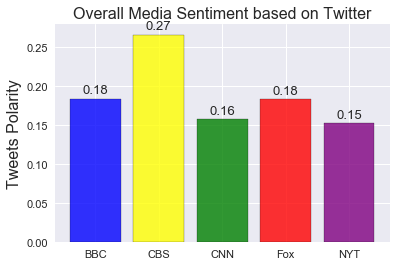

In [80]:
fig, ax = plt.subplots()
rects1 = plt.bar(over_all_sentiment_df.index,over_all_sentiment_df['Compound'], align='center', alpha=0.8,color=['blue', 'yellow','green','red','purple'],edgecolor='black')
plt.ylabel('Tweets Polarity',fontsize=16)
plt.title('Overall Media Sentiment based on Twitter',fontsize=16)

def autolabel(rects, ax):

    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                round(height,2),ha='center', va='bottom')

autolabel(rects1, ax)

plt.savefig("Overall Media Sentiment.png") 
plt.show()